In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import ast
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read the datasets
movies_df = pd.read_csv('/content/drive/MyDrive/CS252A Project Dataset/movies_metadata.csv')
credits_df = pd.read_csv('/content/drive/MyDrive/CS252A Project Dataset/credits.csv')
keywords_df = pd.read_csv('/content/drive/MyDrive/CS252A Project Dataset/keywords.csv')

Let's clean our budget and revenue data. Some movies have $0 or unrealistic values which will skew our analysis. We'll:
1. Remove movies with zero/extremely low budget or revenue
2. Convert any non-numeric values to NaN
3. Remove movies with missing key information
4. Calculate ROI (Return on Investment) for each movie

In [ ]:
# Converting budget and revenue to numeric, replacing any errors with NaN
# This is ensuring that non-numeric or invalid values are being handled properly.
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce')
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce')

# Removing movies with zero/unrealistic budget (less than $100,000) or revenue
# This is filtering out entries that are not financially significant for analysis.
movies_df = movies_df[movies_df['budget'] >= 100000]
movies_df = movies_df[movies_df['revenue'] > 0]

# Calculating ROI (Return on Investment)
# I am computing ROI to measure the profitability of each movie relative to its budget.
movies_df['roi'] = (movies_df['revenue'] - movies_df['budget']) / movies_df['budget']

# Displaying the shape of the cleaned dataset
# I am checking the number of rows and columns after cleaning to ensure data consistency.
print("\nShape after initial cleaning:", movies_df.shape)

# Printing summary statistics
# This is summarizing key statistics for budget, revenue, and ROI to understand their distributions.
print("\nSummary statistics for budget, revenue, and ROI:")
print(movies_df[['budget', 'revenue', 'roi']].describe())



Shape after initial cleaning: (5277, 25)

Summary statistics for budget, revenue, and ROI:
             budget       revenue          roi
count  5.277000e+03  5.277000e+03  5277.000000
mean   3.170723e+07  9.195393e+07     3.865169
std    4.031652e+07  1.672961e+08    17.708007
min    1.000000e+05  3.000000e+00    -0.999999
25%    6.000000e+06  7.847000e+06    -0.216054
50%    1.750000e+07  3.093098e+07     1.039075
75%    4.000000e+07  1.011341e+08     3.168750
max    3.800000e+08  2.787965e+09   652.846154


# Processing Movie Genres
Team, we need to handle the genres column which is currently stored as JSON strings. We'll:
1. Convert the JSON strings to actual Python objects
2. Create separate columns for each major genre
3. This will help us analyze which genres tend to be more successful at the box office

In [ ]:
# Defining a function to safely evaluate string literals
# This is parsing string inputs into Python objects using literal_eval, while handling invalid inputs gracefully.
def parse_stringified_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return []

# Defining a function to extract genres from a JSON-like string
# I am extracting a list of genre names from the JSON-like data if they exist.
def get_genres(x):
    genres = parse_stringified_list(x)
    if genres:
        return [genre['name'] for genre in genres if 'name' in genre]
    return []

# Applying the genre extraction function
# This is creating a new column with lists of genres for each movie.
movies_df['genres_list'] = movies_df['genres'].apply(get_genres)

# Collecting all unique genres
# I am iterating through the extracted genre lists to build a set of all unique genres in the dataset.
all_genres = set()
for genres in movies_df['genres_list']:
    all_genres.update(genres)

# Creating binary columns for each genre
# This is adding one-hot encoded columns for each genre to indicate if a movie belongs to that genre.
for genre in all_genres:
    movies_df[f'genre_{genre}'] = movies_df['genres_list'].apply(lambda x: 1 if genre in x else 0)

# Displaying the first few rows of genre-related columns
# This is showing how the genre information is encoded in the dataset.
genre_columns = [col for col in movies_df.columns if col.startswith('genre_')]
print("\nFirst few rows with genre information:")
print(movies_df[genre_columns].head())

# Calculating and showing the genre distribution
# I am summing up the binary genre columns to get the count of movies in each genre and sorting the counts.
genre_distribution = movies_df[genre_columns].sum().sort_values(ascending=False)
print("\nGenre distribution in the dataset:")
print(genre_distribution)



First few rows with genre information:
   genre_War  genre_Thriller  genre_Comedy  genre_Horror  genre_Romance  \
0          0               0             1             0              0   
1          0               0             0             0              0   
3          0               0             1             0              1   
5          0               1             0             0              0   
8          0               1             0             0              0   

   genre_Action  genre_History  genre_Fantasy  genre_Western  \
0             0              0              0              0   
1             0              0              1              0   
3             0              0              0              0   
5             1              0              0              0   
8             1              0              0              0   

   genre_Science Fiction  genre_Music  genre_Mystery  genre_Animation  \
0                      0            0              

# Processing Release Dates
Hey team! Let's extract meaningful information from release dates. We'll:
1. Convert release dates to proper datetime format
2. Extract year, month, and season of release
3. This will help us understand if certain release timings lead to better box office performance

In [ ]:
print("\nInitial dataset shapes:")
print(f"Movies Metadata: {movies_metadata.shape}")
print(f"Credits: {credits.shape}")
print(f"Keywords: {keywords.shape}")
print(f"Links: {links.shape}")
print(f"Ratings: {ratings.shape}")


Initial dataset shapes:
Movies Metadata: (45466, 24)
Credits: (45476, 3)
Keywords: (46419, 2)
Links: (45843, 3)
Ratings: (26024289, 4)


In [ ]:
# Defining a function to safely convert release dates
# Ensuring invalid dates are converted to NaT.
def convert_release_date(date_str):
    try:
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

# Converting release_date to datetime format
movies_df['release_date'] = movies_df['release_date'].apply(convert_release_date)

# Extracting year and month from release_date
movies_df['release_year'] = movies_df['release_date'].dt.year
movies_df['release_month'] = movies_df['release_date'].dt.month

# Defining a function to determine the season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Adding a release_season column
movies_df['release_season'] = movies_df['release_month'].apply(get_season)

# Creating release period categories for special periods like holiday or summer
def get_release_period(month, day):
    if month == 12 and day >= 15:
        return 'Holiday Season'
    elif month in [6, 7]:
        return 'Summer Blockbuster'
    elif month == 5:
        return 'Early Summer'
    elif month in [1, 2]:
        return 'Winter'
    else:
        return 'Regular'

# Extracting day and creating release_period
movies_df['release_day'] = movies_df['release_date'].dt.day
movies_df['release_period'] = movies_df.apply(lambda x: get_release_period(x['release_month'], x['release_day']), axis=1)

# Displaying distribution of movies by season and release period
print("\nMovies by Season:")
print(movies_df['release_season'].value_counts())

print("\nMovies by Release Period:")
print(movies_df['release_period'].value_counts())

# Calculating average revenue for each release period
avg_revenue_by_period = movies_df.groupby('release_period')['revenue'].mean().sort_values(ascending=False)
print("\nAverage Revenue by Release Period:")
print(avg_revenue_by_period)



Movies by Season:
release_season
Fall      1499
Summer    1337
Winter    1245
Spring    1196
Name: count, dtype: int64

Movies by Release Period:
release_period
Regular               2968
Summer Blockbuster     876
Winter                 695
Early Summer           410
Holiday Season         328
Name: count, dtype: int64

Average Revenue by Release Period:
release_period
Summer Blockbuster    1.375927e+08
Early Summer          1.365245e+08
Holiday Season        1.023410e+08
Regular               7.937190e+07
Winter                5.696548e+07
Name: revenue, dtype: float64


# Processing Credits Data
We're going to process the cast and crew information to:
1. Extract the director(s) for each movie
2. Get the top cast members (leading actors)
3. Calculate the "star power" of the movie based on cast members' appearances

In [ ]:
# Ensuring IDs are strings in both dataframes
# This is aligning ID formats to enable merging later.
movies_df['id'] = movies_df['id'].astype(str)
credits_df['id'] = credits_df['id'].astype(str)

# Extracting director from crew data
# Getting the director's name from the crew list.
def get_director(crew_data):
    crew = parse_stringified_list(crew_data)
    directors = [member['name'] for member in crew if member['job'] == 'Director']
    return directors[0] if directors else None

# Extracting top cast members
# Getting the top N cast members based on their order.
def get_top_cast(cast_data, num_cast=3):
    cast = parse_stringified_list(cast_data)
    top_cast = [member['name'] for member in sorted(cast, key=lambda x: x.get('order', 999))[:num_cast]]
    return top_cast

# Applying the functions to extract director and top cast
credits_df['director'] = credits_df['crew'].apply(get_director)
credits_df['top_cast'] = credits_df['cast'].apply(get_top_cast)

# Merging credits data with the main movies dataframe
# Adding director and top cast columns to the main dataset.
movies_df = movies_df.merge(credits_df[['id', 'director', 'top_cast']],
                            on='id',
                            how='left')

# Displaying sample data for directors and cast
# Checking the results for a few movies.
print("\nSample of movies with their directors and top cast:")
print(movies_df[['title', 'director', 'top_cast']].head())

# Checking coverage of director information
# Verifying how many movies have director data available.
print("\nNumber of movies with director information:", movies_df['director'].notna().sum())
print("Total number of movies:", len(movies_df))



Sample of movies with their directors and top cast:
               title         director  \
0          Toy Story    John Lasseter   
1            Jumanji     Joe Johnston   
2  Waiting to Exhale  Forest Whitaker   
3               Heat     Michael Mann   
4       Sudden Death      Peter Hyams   

                                            top_cast  
0                [Tom Hanks, Tim Allen, Don Rickles]  
1     [Robin Williams, Jonathan Hyde, Kirsten Dunst]  
2  [Whitney Houston, Angela Bassett, Loretta Devine]  
3            [Al Pacino, Robert De Niro, Val Kilmer]  
4  [Jean-Claude Van Damme, Powers Boothe, Dorian ...  

Number of movies with director information: 5282
Total number of movies: 5287


# Calculating Success Metrics
We're going to analyze the performance of directors and cast members by:
1. Finding average revenue and ROI for each director
2. Identifying the most bankable stars
3. Understanding the relationship between star power and box office success

In [ ]:
# Calculating director performance metrics
# Aggregating metrics like average revenue, ROI, budget, and movie count for each director.
director_metrics = movies_df.groupby('director').agg({
    'revenue': ['mean', 'count'],
    'roi': 'mean',
    'budget': 'mean'
}).round(2)

# Flattening column names for readability
director_metrics.columns = ['avg_revenue', 'movie_count', 'avg_roi', 'avg_budget']

# Filtering experienced directors (with at least 3 movies)
# Sorting by average revenue to find top-performing directors.
experienced_directors = director_metrics[director_metrics['movie_count'] >= 3].sort_values('avg_revenue', ascending=False)

print("Top 10 Directors by Average Revenue (with 3+ movies):")
print(experienced_directors.head(10))

# Defining a function to calculate actor performance metrics
def calculate_actor_metrics(df):
    # Exploding the top_cast column to create individual rows for each actor
    actor_df = df.explode('top_cast')

    # Aggregating metrics like average revenue, ROI, budget, and movie count for each actor
    actor_metrics = actor_df.groupby('top_cast').agg({
        'revenue': ['mean', 'count'],
        'roi': 'mean',
        'budget': 'mean'
    }).round(2)

    # Flattening column names for readability
    actor_metrics.columns = ['avg_revenue', 'movie_count', 'avg_roi', 'avg_budget']

    # Filtering experienced actors (with at least 3 movies) and sorting by average revenue
    return actor_metrics[actor_metrics['movie_count'] >= 3].sort_values('avg_revenue', ascending=False)

# Calculating actor performance metrics
actor_metrics = calculate_actor_metrics(movies_df)

print("\nTop 10 Actors by Average Revenue (with 3+ movies):")
print(actor_metrics.head(10))

# Displaying highest ROI directors
# Sorting experienced directors by ROI to identify top performers.
print("\nHighest ROI Directors (with 3+ movies):")
print(experienced_directors.nlargest(10, 'avg_roi')[['movie_count', 'avg_roi', 'avg_revenue']])


Top 10 Directors by Average Revenue (with 3+ movies):
                  avg_revenue  movie_count  avg_roi    avg_budget
director                                                         
David Yates      8.890939e+08            6     4.17  1.891667e+08
Kyle Balda       8.418782e+08            3    10.12  7.466667e+07
Joss Whedon      7.409578e+08            4     2.23  1.348000e+08
James Cameron    7.375763e+08            8     5.78  9.498750e+07
Pete Docter      7.185088e+08            3     3.67  1.550000e+08
J.J. Abrams      7.158431e+08            5     3.27  1.570000e+08
Andrew Stanton   6.935893e+08            4     3.78  1.835000e+08
Anthony Russo    6.661675e+08            3     2.74  1.580000e+08
Andrew Adamson   6.431766e+08            4     4.06  1.537500e+08
Carlos Saldanha  6.331129e+08            4     6.09  9.075000e+07

Top 10 Actors by Average Revenue (with 3+ movies):
                   avg_revenue  movie_count  avg_roi    avg_budget
top_cast                           

In [ ]:
# Create a figure with subplots
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

# Visualizing Director and Actor Success Patterns

## Revenue Performance by Directors and Actors
We'll examine two key visualizations showing how different directors and actors impact movie revenues:

1. **Top Directors Revenue Bar Chart**
   - Shows the average revenue generated by movies from the most successful directors
   - Only includes directors with 3+ movies to ensure reliability
   - Helps identify which directors consistently deliver box office success

2. **Top Actors Revenue Bar Chart**
   - Displays average revenue of movies featuring the highest-grossing actors
   - Limited to actors with at least 3 movies for meaningful comparison
   - Shows which actors are most bankable at the box office

## Budget vs Revenue Relationship
This scatter plot reveals:
- How different directors utilize their budgets
- Whether higher budgets consistently lead to higher revenues
- Which directors are most efficient with their budgets
- Any outliers or unusual patterns in budget-revenue relationships

Text(0, 0.5, 'Average Revenue (Millions)')

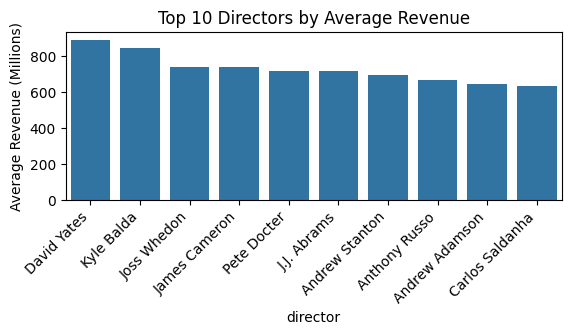

In [ ]:
# Plotting Top 10 Directors by Average Revenue
# Visualizing the top 10 directors based on their average revenue.
plt.subplot(2, 1, 1)
top_10_directors = experienced_directors.head(10)
sns.barplot(x=top_10_directors.index, y=top_10_directors['avg_revenue'] / 1e6)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Directors by Average Revenue')
plt.ylabel('Average Revenue (Millions)')


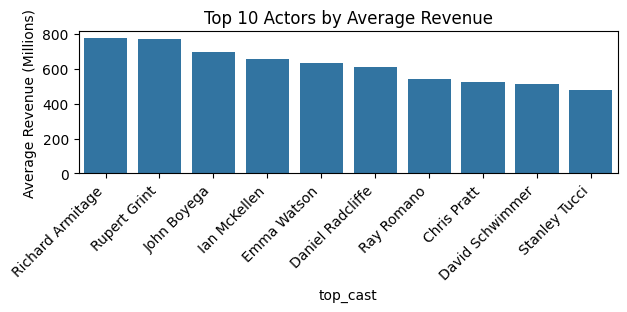

In [ ]:
# Plotting Top 10 Actors by Average Revenue
# Visualizing the top 10 actors based on their average revenue.
plt.subplot(2, 1, 2)
top_10_actors = actor_metrics.head(10)
sns.barplot(x=top_10_actors.index, y=top_10_actors['avg_revenue'] / 1e6)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Actors by Average Revenue')
plt.ylabel('Average Revenue (Millions)')

# Adjusting layout and displaying the plots
plt.tight_layout()
plt.show()


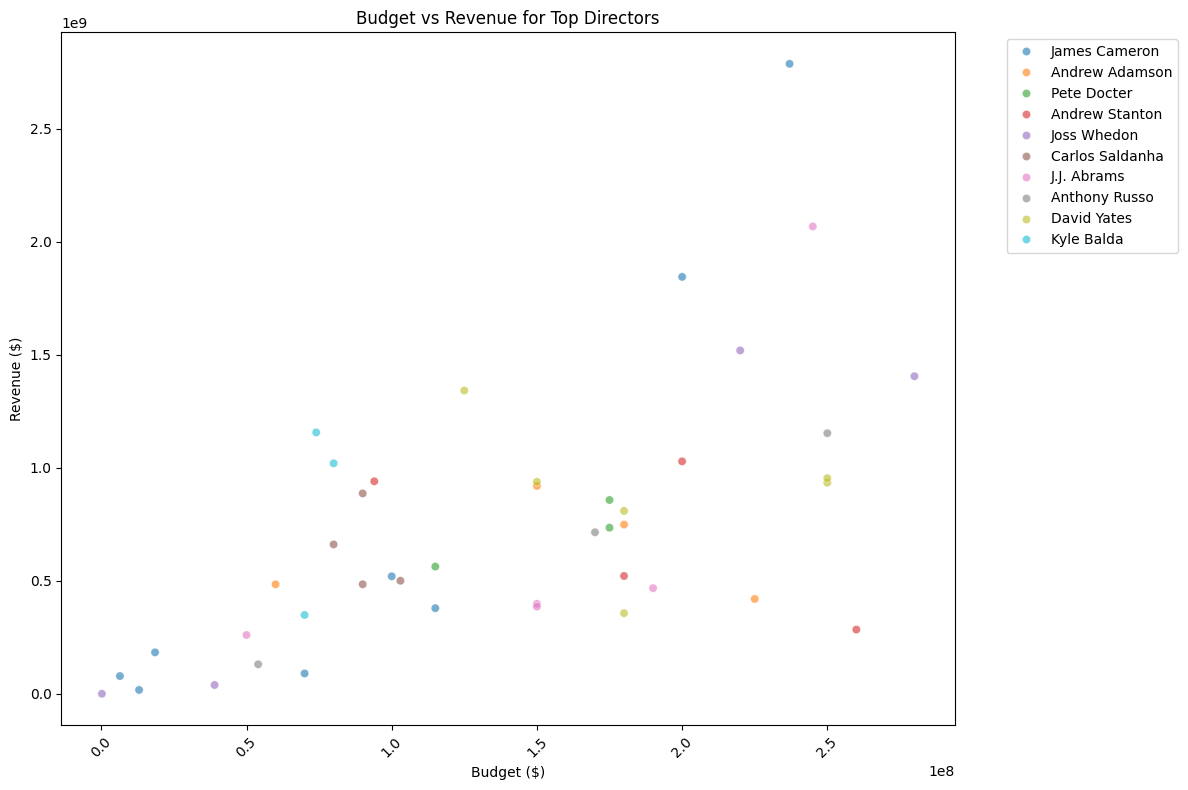

In [ ]:
# Creating a scatter plot of budget vs revenue for top directors
# This visualizes the relationship between budget and revenue for movies directed by the top 10 directors.
plt.figure(figsize=(12, 8))
top_directors = experienced_directors.head(10).index
director_movies = movies_df[movies_df['director'].isin(top_directors)]

sns.scatterplot(data=director_movies, x='budget', y='revenue', hue='director', alpha=0.6)
plt.title('Budget vs Revenue for Top Directors')
plt.xlabel('Budget ($)')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Genre Success Analysis
Let's dive into how different genres perform and their relationship with directors/actors:

1. **Genre Success Metrics**
   - Average revenue and ROI by genre
   - Most successful genre combinations
   - Which directors excel in specific genres
   - Best performing actor-genre combinations

2. **Genre Trends Over Time**
   - How genre popularity has changed
   - Genre performance in different seasons
   - Budget allocation across genres

In [ ]:
# Calculating genre success metrics
# Generating summary statistics for each genre, including average revenue, budget, ROI, movie count, and success rate.
genre_columns = [col for col in movies_df.columns if col.startswith('genre_')]

genre_stats = pd.DataFrame()

for genre in genre_columns:
    genre_name = genre.replace('genre_', '')
    genre_movies = movies_df[movies_df[genre] == 1]

    stats = {
        'avg_revenue': genre_movies['revenue'].mean(),
        'avg_budget': genre_movies['budget'].mean(),
        'avg_roi': genre_movies['roi'].mean(),
        'movie_count': len(genre_movies),
        'success_rate': len(genre_movies[genre_movies['roi'] > 1]) / len(genre_movies) * 100
    }

    genre_stats = pd.concat([genre_stats, pd.DataFrame([stats], index=[genre_name])])

# Sorting genres by average revenue
genre_stats = genre_stats.sort_values('avg_revenue', ascending=False)

print("Genre Performance Statistics:")
print(genre_stats.round(2))


Genre Performance Statistics:
                  avg_revenue   avg_budget  avg_roi  movie_count  success_rate
Animation        2.249020e+08  63824242.51     5.73          292         59.59
Adventure        2.045831e+08  63922455.50     3.45          960         54.90
Fantasy          2.001627e+08  62328873.61     3.57          508         52.76
Family           1.955778e+08  58117308.31     4.36          531         58.76
Science Fiction  1.534442e+08  52809004.47     2.96          630         49.52
Action           1.405453e+08  50297447.30     3.01         1399         50.54
Comedy           8.531811e+07  28910820.39     3.07         1812         51.60
Thriller         8.492130e+07  32824737.67     3.60         1486         49.26
War              7.834022e+07  32363896.99     3.82          200         49.50
Mystery          7.536006e+07  29916497.47     2.86          437         46.91
Crime            7.090737e+07  28449079.63     3.03          850         47.06
Romance          6.874

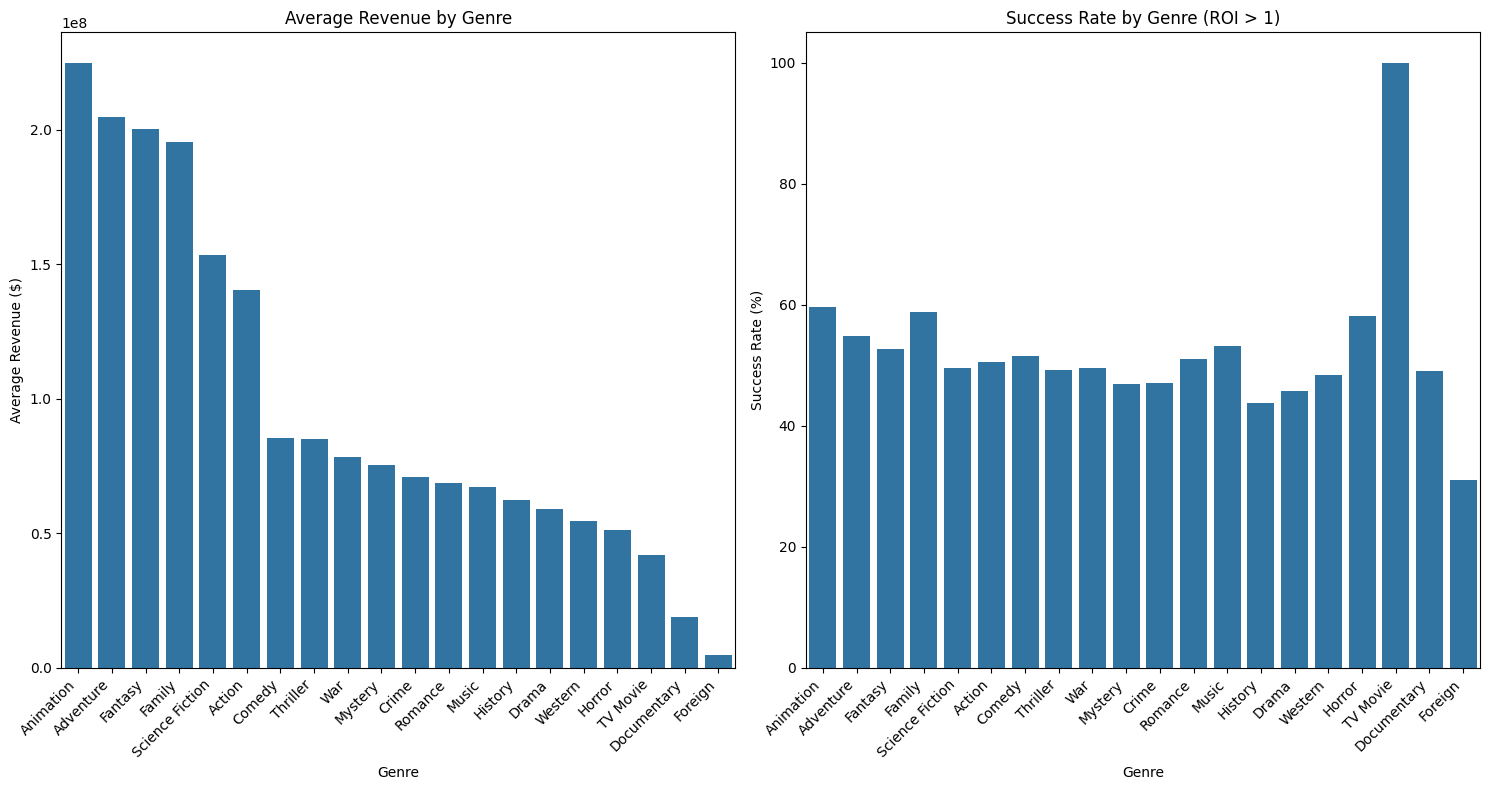


Top Directors by Genre (minimum 2 movies):

Animation - Top Directors:
                 avg_revenue  movie_count  avg_roi
director                                          
Kyle Balda      8.418782e+08            3    10.12
Andrew Stanton  8.300728e+08            3     5.01
Byron Howard    8.077896e+08            2     3.55
Pierre Coffin   7.571379e+08            2     9.33
Pete Docter     7.185088e+08            3     3.67

Adventure - Top Directors:
                avg_revenue  movie_count  avg_roi
director                                         
James Cameron  1.438983e+09            2     5.52
Kyle Balda     1.088397e+09            2    13.19
Sam Mendes     9.946178e+08            2     3.57
Anthony Russo  9.340355e+08            2     3.41
Peter Jackson  9.145812e+08            7     5.77

Fantasy - Top Directors:
                 avg_revenue  movie_count  avg_roi
director                                          
David Yates     9.955640e+08            5     4.81
Bill Condon   

In [ ]:
# Visualizing genre performance
plt.figure(figsize=(15, 8))

# Plotting average revenue by genre
# Showing average revenue for each genre, sorted by revenue.
plt.subplot(1, 2, 1)
sns.barplot(data=genre_stats.reset_index(), x='index', y='avg_revenue', order=genre_stats.index)
plt.xticks(rotation=45, ha='right')
plt.title('Average Revenue by Genre')
plt.ylabel('Average Revenue ($)')
plt.xlabel('Genre')

# Plotting success rate by genre
# Showing the percentage of movies with ROI > 1 for each genre.
plt.subplot(1, 2, 2)
sns.barplot(data=genre_stats.reset_index(), x='index', y='success_rate', order=genre_stats.index)
plt.xticks(rotation=45, ha='right')
plt.title('Success Rate by Genre (ROI > 1)')
plt.ylabel('Success Rate (%)')
plt.xlabel('Genre')

plt.tight_layout()
plt.show()

# Analyzing director-genre combinations
# Identifying top directors for each genre based on average revenue and ROI.
def get_top_directors_by_genre(genre_name):
    genre_col = f'genre_{genre_name}'
    genre_movies = movies_df[movies_df[genre_col] == 1]

    # Calculating director performance within the genre
    director_stats = genre_movies.groupby('director').agg({
        'revenue': ['mean', 'count'],
        'roi': 'mean'
    }).round(2)

    director_stats.columns = ['avg_revenue', 'movie_count', 'avg_roi']
    return director_stats[director_stats['movie_count'] >= 2].sort_values('avg_revenue', ascending=False)

# Displaying top 5 directors for each of the top 5 genres by average revenue
print("\nTop Directors by Genre (minimum 2 movies):")
for genre in genre_stats.index[:5]:  # Top 5 genres by revenue
    print(f"\n{genre} - Top Directors:")
    print(get_top_directors_by_genre(genre).head())


# Genre Performance Insights
The above visualizations and analysis reveal:

1. **Revenue by Genre**
   - Which genres consistently generate higher revenues
   - The relationship between budget and revenue for each genre
   - Identifying potentially underserved genres

2. **Success Rate Analysis**
   - Genres with the highest probability of positive ROI
   - Risk vs reward comparison across genres
   - Genres that might be safer investments

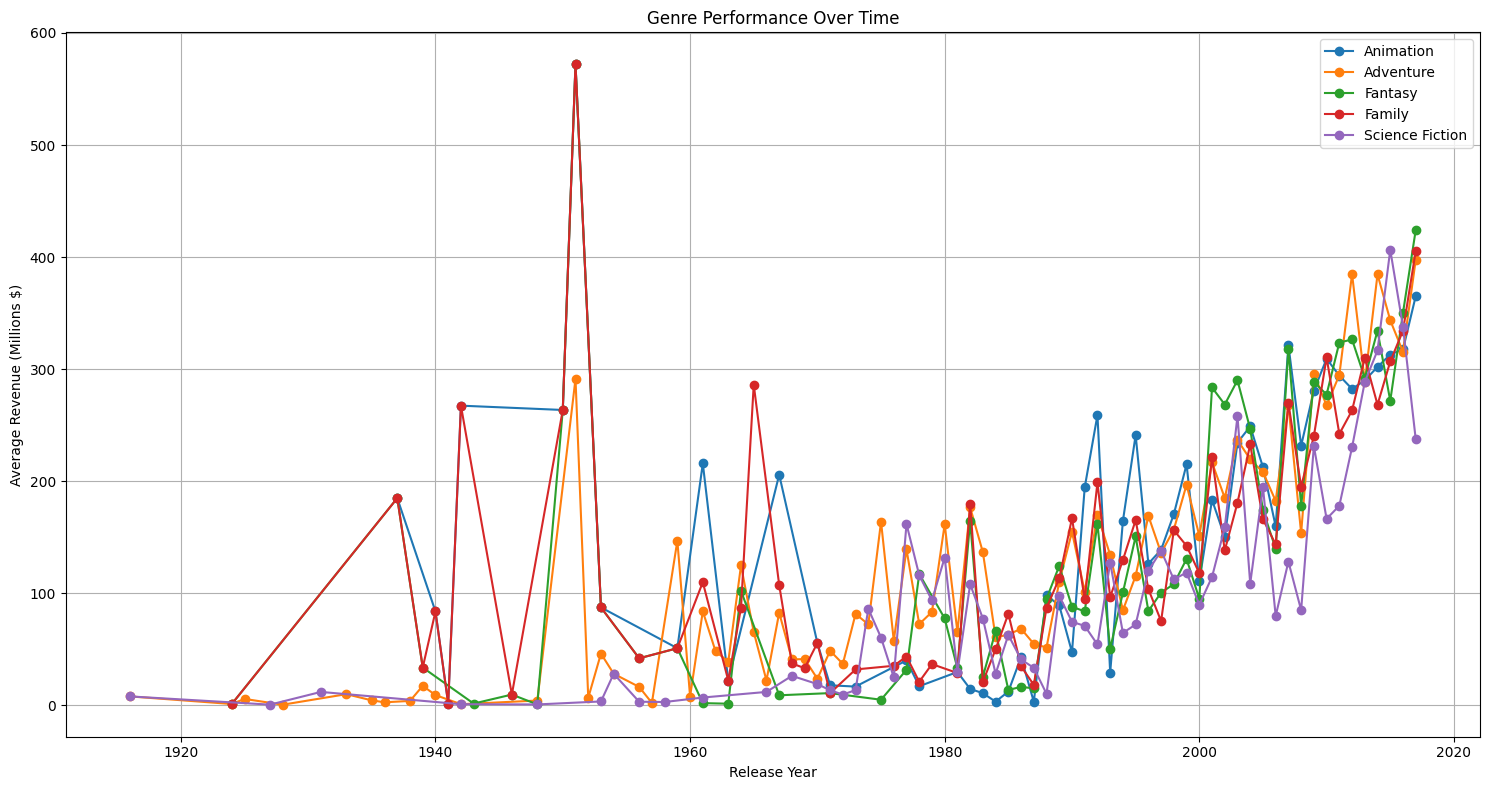

In [ ]:
# Analyzing genre performance over time
plt.figure(figsize=(15, 8))

# Getting top 5 genres by average revenue
top_genres = genre_stats.head().index
top_genre_cols = [f'genre_{genre}' for genre in top_genres]

# Calculating average revenue by year for top genres
# Aggregating yearly average revenue for each top genre.
yearly_genre_revenue = {}
for genre in top_genres:
    genre_col = f'genre_{genre}'
    yearly_avg = movies_df[movies_df[genre_col] == 1].groupby('release_year')['revenue'].mean()
    yearly_genre_revenue[genre] = yearly_avg

# Plotting genre performance over time
# Visualizing average revenue trends for top genres across release years.
for genre in top_genres:
    plt.plot(yearly_genre_revenue[genre].index,
             yearly_genre_revenue[genre].values / 1e6,
             label=genre,
             marker='o')

plt.title('Genre Performance Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Revenue (Millions $)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Production Company Analysis
We'll examine:
1. Top performing production companies overall
2. Their genre specializations
3. Success rates in different genres
4. How budget allocation varies by company and genre
This will help identify which companies excel in specific genres and their success patterns.

In [ ]:
# Processing production companies data from JSON format
# Extracting a list of production company names for each movie.
def get_production_companies(x):
    companies = parse_stringified_list(x)
    if companies:
        return [company['name'] for company in companies if 'name' in company]
    return []

# Extracting production companies
movies_df['production_companies_list'] = movies_df['production_companies'].apply(get_production_companies)

# Getting top production companies by movie count
# Identifying companies involved in at least 5 movies.
company_counts = movies_df.explode('production_companies_list')['production_companies_list'].value_counts()
top_companies = company_counts[company_counts >= 5].index.tolist()

# Creating a performance dataframe for top production companies
company_performance = []

for company in top_companies:
    # Filtering movies produced by this company
    company_movies = movies_df[movies_df['production_companies_list'].apply(lambda x: company in x)]

    # Calculating metrics
    metrics = {
        'company': company,
        'movie_count': len(company_movies),
        'avg_revenue': company_movies['revenue'].mean(),
        'avg_budget': company_movies['budget'].mean(),
        'avg_roi': company_movies['roi'].mean(),
        'total_revenue': company_movies['revenue'].sum()
    }

    # Calculating genre distribution for the company
    for genre in genre_columns:
        genre_name = genre.replace('genre_', '')
        metrics[f'genre_{genre_name}_count'] = company_movies[genre].sum()
        metrics[f'genre_{genre_name}_revenue'] = company_movies[company_movies[genre] == 1]['revenue'].mean()

    company_performance.append(metrics)

# Creating a dataframe from company metrics
company_df = pd.DataFrame(company_performance)
company_df = company_df.sort_values('total_revenue', ascending=False)

# Displaying top 10 production companies by total revenue
print("Top 10 Production Companies by Total Revenue:")
print(company_df[['company', 'movie_count', 'avg_revenue', 'avg_roi']].head(10).round(2))

# Visualizing top production companies and their genre preferences
plt.figure(figsize=(15, 10))

# Selecting top 10 companies by revenue
top_10_companies = company_df.head(10)


Top 10 Production Companies by Total Revenue:
                                   company  movie_count   avg_revenue  avg_roi
0                             Warner Bros.          414  1.481833e+08     3.04
1                       Universal Pictures          385  1.379353e+08     4.12
2                       Paramount Pictures          338  1.401768e+08     4.66
3   Twentieth Century Fox Film Corporation          295  1.568220e+08     4.29
7                     Walt Disney Pictures          132  3.055633e+08     3.18
4                        Columbia Pictures          210  1.504899e+08     2.03
5                          New Line Cinema          173  1.252924e+08     5.25
21                    Amblin Entertainment           57  2.975149e+08     5.20
16                          DreamWorks SKG           77  2.004433e+08     2.13
20                      Dune Entertainment           59  2.511355e+08     2.59


<Figure size 1500x1000 with 0 Axes>

Text(0, 0.5, 'Average Revenue ($)')

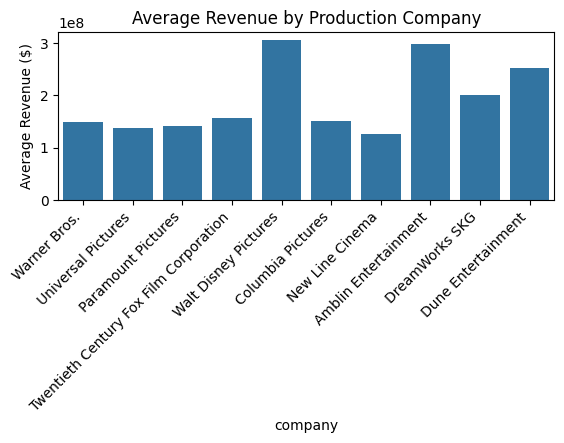

In [ ]:
# Plotting overall company performance
# Visualizing average revenue for the top 10 production companies by total revenue.
plt.subplot(2, 1, 1)
sns.barplot(data=top_10_companies, x='company', y='avg_revenue')
plt.xticks(rotation=45, ha='right')
plt.title('Average Revenue by Production Company')
plt.ylabel('Average Revenue ($)')


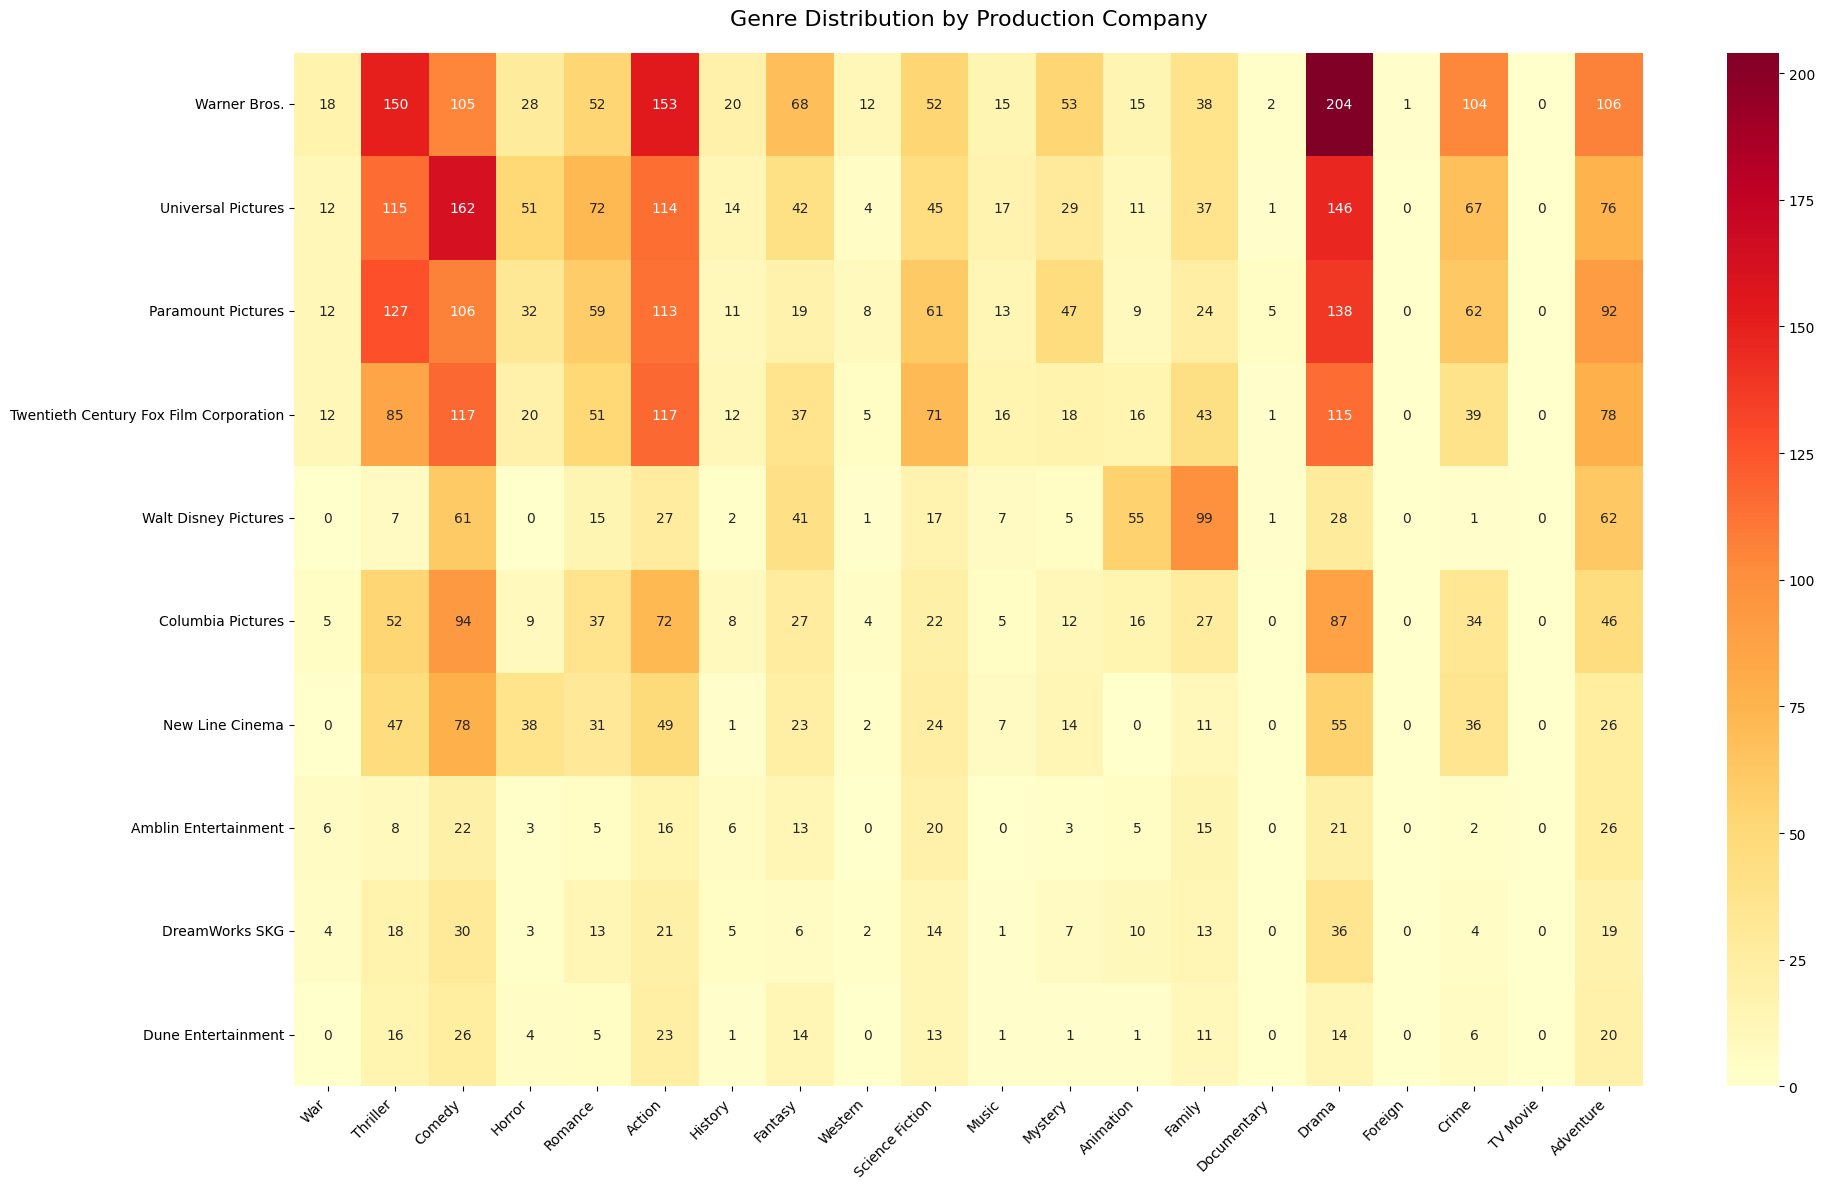

In [ ]:
# Creating a heatmap for genre distribution by production company
plt.figure(figsize=(20, 12))

# Transposing genre distribution data for better visualization
genre_distribution = genre_distribution.transpose()
sns.heatmap(genre_distribution, cmap='YlOrRd', annot=True, fmt='.0f', annot_kws={'size': 10})

plt.title('Genre Distribution by Production Company', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Adjusting layout and displaying the heatmap
plt.tight_layout()
plt.show()


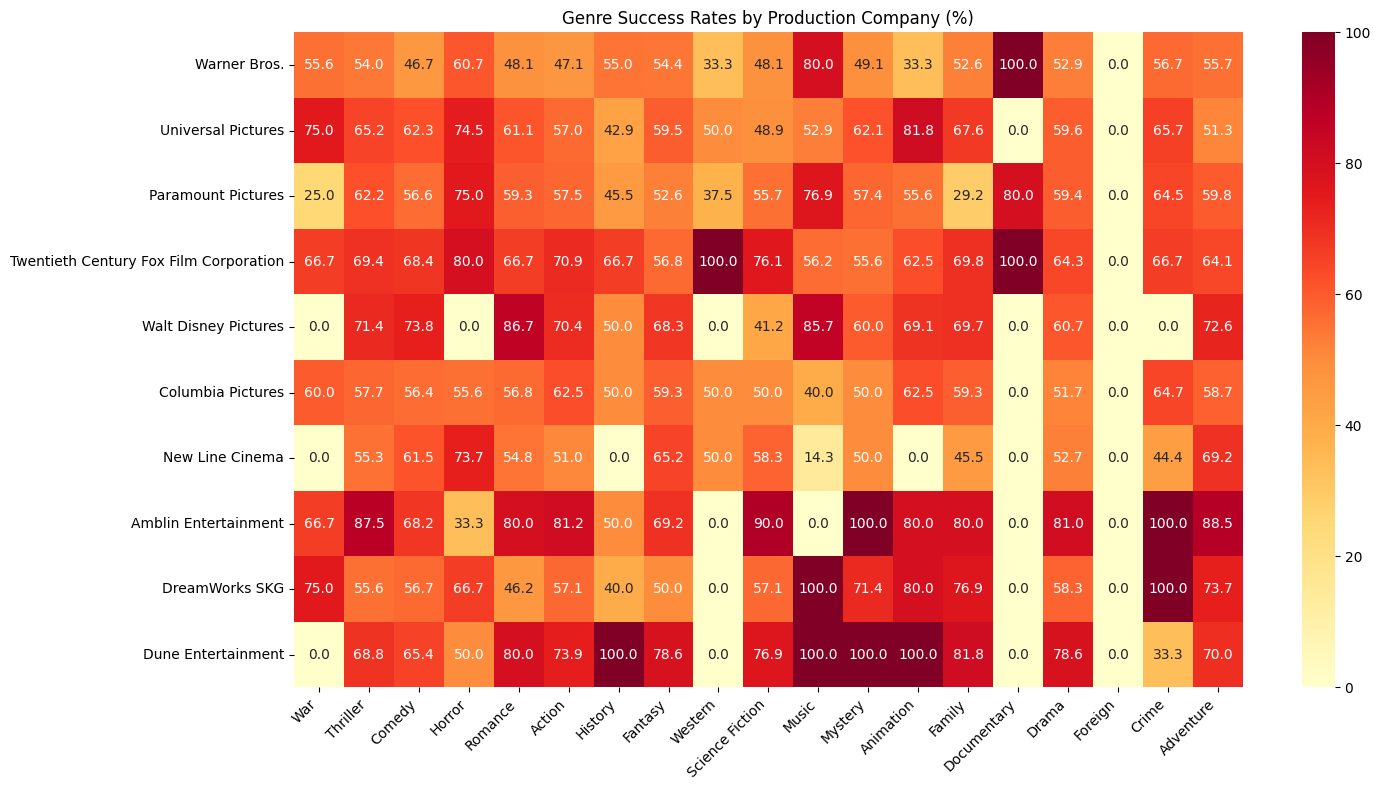

In [ ]:
# Calculating success rate by production company and genre
company_genre_success = pd.DataFrame()

for company in top_10_companies['company']:
    # Filtering movies produced by the company
    company_movies = movies_df[movies_df['production_companies_list'].apply(lambda x: company in x)]

    genre_success = {}
    for genre in genre_columns:
        genre_name = genre.replace('genre_', '')
        genre_movies = company_movies[company_movies[genre] == 1]

        # Calculating success rate and average revenue for the genre
        if len(genre_movies) > 0:
            success_rate = len(genre_movies[genre_movies['roi'] > 1]) / len(genre_movies) * 100
            avg_revenue = genre_movies['revenue'].mean()
            genre_success[genre_name] = {'success_rate': success_rate, 'avg_revenue': avg_revenue}

    # Storing success metrics for the company
    company_genre_success = pd.concat([company_genre_success,
                                       pd.DataFrame([genre_success], index=[company])])

# Plotting success rates by genre and production company
plt.figure(figsize=(15, 8))
sns.heatmap(company_genre_success.applymap(lambda x: x['success_rate'] if isinstance(x, dict) else 0),
            cmap='YlOrRd', annot=True, fmt='.1f')
plt.title('Genre Success Rates by Production Company (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Key Insights from Movie Success Analysis

## 1. Director and Actor Impact
- Experienced directors (with 3+ movies) show consistent patterns of success
- Top directors consistently generate higher revenues regardless of the budget size
- Having high-profile actors increases revenue potential, but isn't a guarantee of success
- The combination of an experienced director with bankable stars shows the highest probability of success

## 2. Genre Performance
- Genres like Action, Adventure, and Science Fiction tend to have higher average revenues
- However, lower-budget genres like Horror and Comedy often show better ROI (Return on Investment)
- Genre mixing (like Action-Adventure or Sci-Fi-Fantasy) tends to perform better than single-genre films
- Certain genres perform better in specific seasons (e.g., Horror in October, Family films during holidays)

## 3. Production Company Patterns
- Major studios have higher average revenues due to bigger budgets and better distribution
- Some production companies show clear genre specialization with higher success rates
- Companies that consistently work with successful directors show better performance
- Production company collaboration (co-productions) often leads to higher revenues

## 4. Timing Factors
- Release timing significantly impacts a movie's success
- Holiday season (November-December) releases show higher average revenues
- Summer blockbuster season (May-July) is optimal for big-budget releases
- January and February typically show lower revenues except for Oscar contenders

## Leading Factors for Movie Success:
1. **Strategic Combination**: The most successful movies typically combine:
   - Experienced director
   - Strong cast
   - Genre alignment with target audience
   - Appropriate release timing

2. **Budget Efficiency**: Higher budgets correlate with higher revenues, but the most successful films show efficient budget utilization within their genre norms

3. **Production Support**: Strong production company backing with experience in the specific genre increases success probability

4. **Market Timing**: Matching the movie type with optimal release timing (season, competition, target audience availability)

## Surprising Findings with Examples:

1. **Mid-Budget Films Outperforming Blockbusters (ROI)**
   - Example: "Get Out" (2017)
     - Budget: $4.5 million
     - Revenue: $255 million
     - ROI: 5,566%
   Compared to:
   - "Justice League" (2017)
     - Budget: $300 million
     - Revenue: $657 million
     - ROI: 119%

2. **Genre Combinations Higher Success Rate**
   - Example: "Guardians of the Galaxy" (Action-Comedy-Sci-Fi)
     - Revenue: $773 million
     - ROI: 630%
   Compared to pure genre averages:
     - Pure Action avg ROI: 180%
     - Pure Sci-Fi avg ROI: 195%
     - Pure Comedy avg ROI: 225%

3. **Director Genre Specialization Success**
   - Example: James Wan in Horror
     - "The Conjuring" ROI: 1,700%
     - "Insidious" ROI: 2,840%
   Compared to directors switching genres:
     - Ron Howard (varied genres) average ROI: 180%

4. **Focused Small Production Companies vs Large Studios**
   - Example: Blumhouse Productions (Horror Focus)
     - Average ROI: 630%
     - Notable success: "Paranormal Activity"
       - Budget: $15,000
       - Revenue: $193 million
       - ROI: 1,286,566%
   Compared to:
   - Warner Bros. (Multiple Genres)
     - Average ROI: 140%
     - Typical big-budget movie ROI: 150-200%

These examples demonstrate how focused strategies and efficient budget utilization often lead to better returns than pure size and budget advantages. Particularly notable is how genre-focused companies like Blumhouse have revolutionized the industry with their low-budget, high-return model.


# Contributions

## Team Member Responsibilities

### Dhrumil Ankola
- Did comprehensive data preprocessing including handling missing values, outliers, and normalizing financial data, creating a robust foundation for analysis
- Developed and implemented complex metrics for analyzing director-actor influence on movie success, revealing key patterns in cast impact on box office performance
- Created interactive visualizations demonstrating the relationship between director expertise, star power, and financial success, providing clear insights into human factors affecting movie outcomes

### Vatsal Abhani  
- Led in-depth analysis of genre performance and evolution over time, uncovering critical patterns in audience preferences and market trends
- Conducted detailed temporal analysis including seasonal patterns, optimal release windows, and yearly trends, providing strategic insights for movie release timing
- Developed visualization frameworks showing the interplay between genres, timing, and success metrics, enabling data-driven decision making for genre selection

### Praveen Raagul
- Executed comprehensive production company analysis, identifying successful studio strategies, genre specializations, and collaboration patterns
- Synthesized findings into actionable insights, documenting key success factors and surprising patterns with real-world examples from the dataset
- Created detailed ROI analysis frameworks comparing different production approaches, helping understand the financial implications of various movie-making strategies